# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

!pip install albucore==0.0.23
!pip install -U albumentations



  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-i2p7kiub
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-i2p7kiub
  Resolved https://github.com/albumentations-team/albumentations to commit f79daf462d7eace6c32a3b72501b08544bb877bd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached albucore-0.0.24-py3-none-any.whl.metadata (5.3 kB)
Using cached albucore-0.0.24-py3-none-any.whl (15 kB)
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.23
    Uninstalling albucore-0.0.23:
      Successfully uninstalled albucore-0.0.23
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.5 requires albucore==0.0.23, but you hav

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [3]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


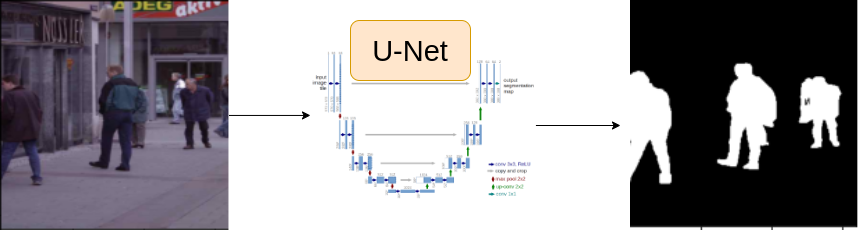

# Some Common Imports

In [4]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [5]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [6]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [7]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [8]:
row = df.iloc[0]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

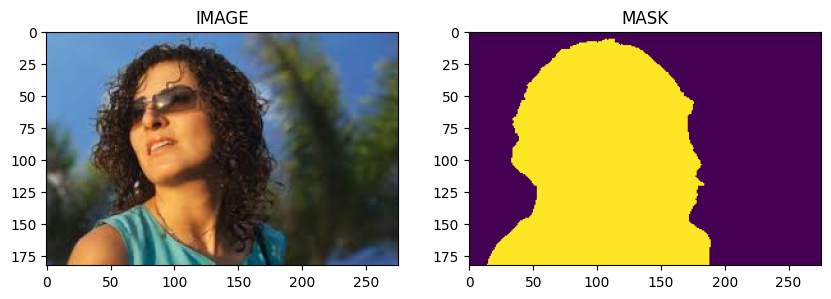

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('MASK')
ax2.imshow(mask)

In [10]:
train_df, valid_df = train_test_split(df,test_size = 0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [11]:
import albumentations as A

In [12]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])


# Task 4 : Create Custom Dataset

In [13]:
from torch.utils.data import Dataset

In [18]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (h, w, c)

    if image is None or mask is None:
            raise ValueError(f"Error loading image or mask at index {idx}. Paths: {image_path}, {mask_path}")

    # Resize both image and mask to the same shape before augmentation
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))




    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    #(h, w, c) -> (c, h, w)

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [19]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [20]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


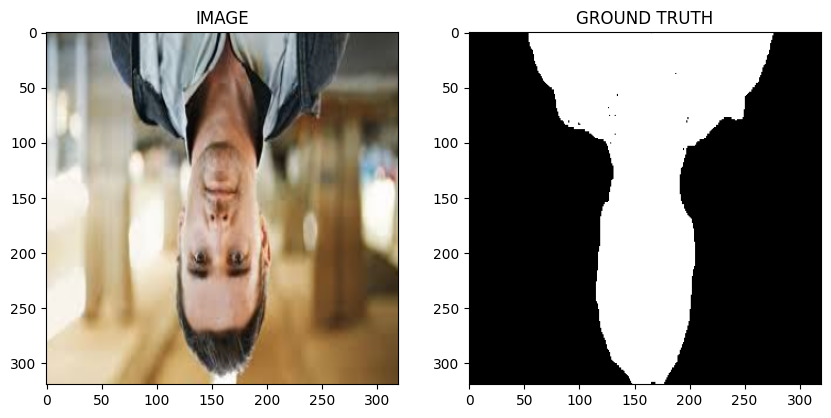

In [23]:
idx = 32

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [24]:
from torch.utils.data import DataLoader

In [25]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [26]:
print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in validloader : {len(validloader)}")

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [27]:
for image, mask in trainloader:
  break


print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [28]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [29]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits


In [31]:
model = SegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function

In [32]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [33]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [35]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED MODEL")
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1}  Train_loss : {train_loss}  Valid_loss : {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  5.95it/s]


SAVED MODEL
Epoch : 1  Train_loss : 0.7695708334445953  Valid_loss : 0.48415688425302505


100%|██████████| 4/4 [00:00<00:00,  6.13it/s]


SAVED MODEL
Epoch : 2  Train_loss : 0.34716642995675406  Valid_loss : 0.3676832243800163


100%|██████████| 4/4 [00:00<00:00,  6.27it/s]


Epoch : 3  Train_loss : 0.3139121174812317  Valid_loss : 0.45186426490545273


100%|██████████| 4/4 [00:00<00:00,  6.26it/s]


SAVED MODEL
Epoch : 4  Train_loss : 0.28028534253438314  Valid_loss : 0.29193102940917015


100%|██████████| 4/4 [00:00<00:00,  6.09it/s]


SAVED MODEL
Epoch : 5  Train_loss : 0.2546255151430766  Valid_loss : 0.25870412588119507


100%|██████████| 4/4 [00:00<00:00,  6.26it/s]


SAVED MODEL
Epoch : 6  Train_loss : 0.21839262942473095  Valid_loss : 0.21419555693864822


100%|██████████| 4/4 [00:00<00:00,  6.10it/s]


Epoch : 7  Train_loss : 0.24139601389567059  Valid_loss : 0.27422476559877396


100%|██████████| 4/4 [00:00<00:00,  5.34it/s]


SAVED MODEL
Epoch : 8  Train_loss : 0.21348577241102853  Valid_loss : 0.21240205317735672


100%|██████████| 4/4 [00:00<00:00,  6.33it/s]


Epoch : 9  Train_loss : 0.16462596406539282  Valid_loss : 0.28069331496953964


100%|██████████| 4/4 [00:00<00:00,  5.63it/s]


Epoch : 10  Train_loss : 0.20243109862009684  Valid_loss : 0.3730553202331066


100%|██████████| 4/4 [00:00<00:00,  6.41it/s]


SAVED MODEL
Epoch : 11  Train_loss : 0.24725285371144612  Valid_loss : 0.2100827880203724


100%|██████████| 4/4 [00:00<00:00,  6.23it/s]


Epoch : 12  Train_loss : 0.1776192680001259  Valid_loss : 0.2422579675912857


100%|██████████| 4/4 [00:00<00:00,  6.30it/s]


Epoch : 13  Train_loss : 0.1722750574350357  Valid_loss : 0.2345128133893013


100%|██████████| 4/4 [00:00<00:00,  6.20it/s]


Epoch : 14  Train_loss : 0.14632057348887126  Valid_loss : 0.3403526619076729


100%|██████████| 4/4 [00:00<00:00,  6.17it/s]


Epoch : 15  Train_loss : 0.13074326515197754  Valid_loss : 0.21395816653966904


100%|██████████| 4/4 [00:00<00:00,  6.23it/s]


Epoch : 16  Train_loss : 0.13390701860189438  Valid_loss : 0.22864114493131638


100%|██████████| 4/4 [00:00<00:00,  5.88it/s]


SAVED MODEL
Epoch : 17  Train_loss : 0.11372562597195307  Valid_loss : 0.19991261139512062


100%|██████████| 4/4 [00:00<00:00,  6.19it/s]


SAVED MODEL
Epoch : 18  Train_loss : 0.12787811408440272  Valid_loss : 0.1686510369181633


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


Epoch : 19  Train_loss : 0.11540547162294387  Valid_loss : 0.17334646731615067


100%|██████████| 4/4 [00:00<00:00,  6.33it/s]


Epoch : 20  Train_loss : 0.09888050059477488  Valid_loss : 0.1958293430507183


100%|██████████| 4/4 [00:00<00:00,  6.26it/s]


Epoch : 21  Train_loss : 0.10622348288695017  Valid_loss : 0.2086614854633808


100%|██████████| 4/4 [00:00<00:00,  6.31it/s]


Epoch : 22  Train_loss : 0.09048878053824107  Valid_loss : 0.24246618524193764


100%|██████████| 4/4 [00:00<00:00,  6.23it/s]


Epoch : 23  Train_loss : 0.09309184749921164  Valid_loss : 0.19592310115695


100%|██████████| 4/4 [00:00<00:00,  6.40it/s]


Epoch : 24  Train_loss : 0.09453814526398976  Valid_loss : 0.20244067162275314


100%|██████████| 4/4 [00:00<00:00,  6.29it/s]

Epoch : 25  Train_loss : 0.09390738407770792  Valid_loss : 0.23226220533251762


# Task 9 : Inference

In [42]:
idx = 12

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(C, H, W) -> (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

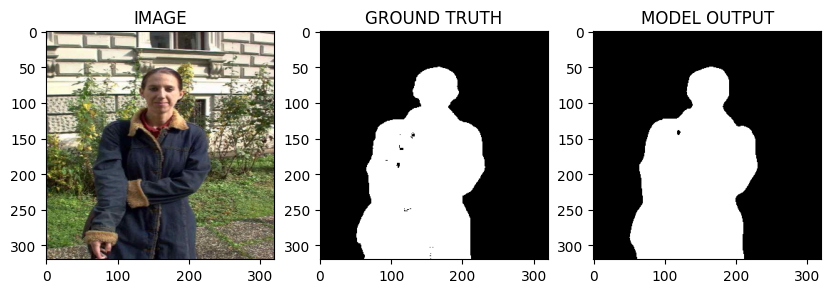

In [43]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya